<a href="https://colab.research.google.com/github/archie10/Karate-Tracker/blob/main/blobdetection1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#sample = torch.randint(3, 1080, 1980, low=0, high=255, device='cuda', requires_grad=False)
# or if you'd like to be more explicit:
sample = torch.randint(1,256,(1080, 1980),device=device, requires_grad=False)

In [ ]:
device

'cuda'

config dict.

In [ ]:
config = {
    "learning_rate": 0.01,
    "epochs": 100,
    "batch_size": 32
    "architecture": 'Linear Model'
}
config = wandb.config

In [ ]:
run = wandb.init(project = "Blob-Detection1D", config = config, name = "Linear-Model")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ak205961 (ak205961-dalhousie-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


api ca8208806d9857c11d07be56650d7463c8be3729

In [ ]:
sample

tensor([[ 34, 161, 154,  ...,  55, 122, 210],
        [114,  61,   1,  ..., 176, 124,   5],
        [ 65, 243,  85,  ...,  19, 109, 118],
        ...,
        [ 29, 159, 208,  ...,  50, 163, 157],
        [ 18, 157, 203,  ..., 254, 238, 123],
        [157,  67,  74,  ..., 244,  83, 124]], device='cuda:0')

In [ ]:
min_area = 80
max_area = 100
height = 1080
width = 1980
block_area = random.randint(min_area, max_area)
block_height = random.randint(1, int(np.sqrt(block_area)) + 1)
block_width = block_area // block_height
block_area


90

In [ ]:
# Determine the random position (top-left corner) of the block
start_row = random.randint(0, height - block_height)
start_col = random.randint(0, width - block_width)

In [ ]:
sample[start_row:start_row + block_height, start_col:start_col + block_width] = 0


In [ ]:
sample.shape

torch.Size([1080, 1980])

In [ ]:
df = pd.DataFrame(columns=['frame','min bounding box', 'max bounding box'])

In [ ]:
df

,frame,min bounding box,max bounding box


Dataset Generation

In [ ]:
def frame_with_blob(min_area, max_area, height, width, device):
    min_area = min_area
    max_area = max_area
    height = height
    width = width
    device = device
    sample = torch.randint(1,256,(1080, 1980),device=device, requires_grad=False)
    block_area = random.randint(min_area, max_area)
    block_height = random.randint(5, int(np.sqrt(block_area)) + 1)
    block_width = block_area // block_height
    start_row = random.randint(0, height - block_height)
    start_col = random.randint(0, width - block_width)
    sample[start_row:start_row + block_height, start_col:start_col + block_width] = 0
    y = torch.where(sample == 0)
    return sample,y


In [ ]:
frame, y =frame_with_blob(80,100,1080,1980,'cpu')

In [ ]:
frame.item

<function Tensor.item>

y is coordinates of 0's as bounding box with random area(80 to 100 pixels). The patch of 0's here is considered blob and the

In [ ]:
y

(tensor([839, 839, 839, 839, 839, 839, 839, 839, 839, 839, 840, 840, 840, 840,
         840, 840, 840, 840, 840, 840, 841, 841, 841, 841, 841, 841, 841, 841,
         841, 841, 842, 842, 842, 842, 842, 842, 842, 842, 842, 842, 843, 843,
         843, 843, 843, 843, 843, 843, 843, 843, 844, 844, 844, 844, 844, 844,
         844, 844, 844, 844, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845,
         846, 846, 846, 846, 846, 846, 846, 846, 846, 846, 847, 847, 847, 847,
         847, 847, 847, 847, 847, 847]),
 tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22,
         23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]))

coordinates_x[-1] create a mean min, max

In [ ]:
def genbboxCoordinates(y):
  X_min = min(y[0])
  X_max = max(y[0])
  Y_min = min(y[1])
  Y_max = max(y[1])
  return X_min, X_max, Y_min, Y_max


In [ ]:
X_min, X_max, Y_min, Y_max = genbboxCoordinates(y)

In [ ]:
X_max

tensor(847)

In [ ]:
X_min

tensor(839)

In [ ]:
Y_min

tensor(15)

In [ ]:
Y_max

tensor(24)

A sample frame with Blob

Text(0.5, 1.0, 'Frame Visualization')

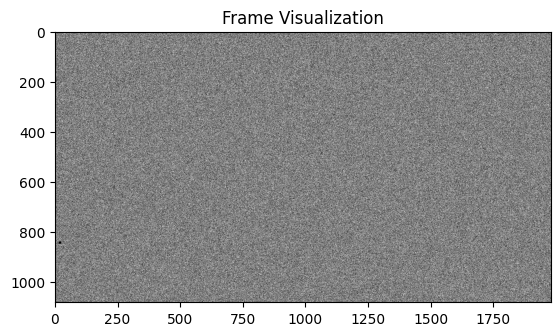

In [ ]:
# Instead of:
# plt.scatterplot(frame)

# Use:
plt.imshow(frame.cpu().numpy(), cmap='grey') # Assuming frame is a grayscale image. Adjust cmap if necessary
plt.title('Frame Visualization')

the sample frame with blob with grouth truth visualized

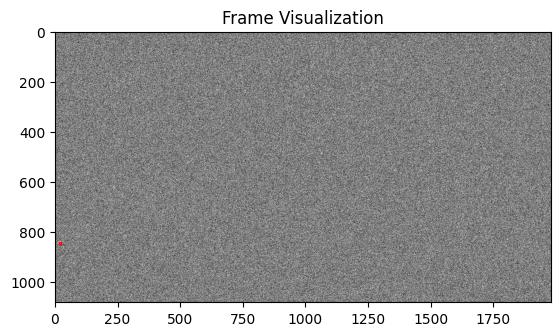

In [ ]:
# prompt: draw bounding box with X_min, X_max, Y_min, Y_max on the frame

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(frame.cpu().numpy(), cmap='binary') # Assuming frame is a grayscale image. Adjust cmap if necessary
plt.title('Frame Visualization')

# Create a Rectangle patch
rect = patches.Rectangle((Y_min, X_min), Y_max - Y_min, X_max - X_min, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [ ]:

y = torch.where(frame == 0)
print(y)

(tensor([839, 839, 839, 839, 839, 839, 839, 839, 839, 839, 840, 840, 840, 840,
        840, 840, 840, 840, 840, 840, 841, 841, 841, 841, 841, 841, 841, 841,
        841, 841, 842, 842, 842, 842, 842, 842, 842, 842, 842, 842, 843, 843,
        843, 843, 843, 843, 843, 843, 843, 843, 844, 844, 844, 844, 844, 844,
        844, 844, 844, 844, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845,
        846, 846, 846, 846, 846, 846, 846, 846, 846, 846, 847, 847, 847, 847,
        847, 847, 847, 847, 847, 847]), tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]))


In [ ]:
torch.set_printoptions(threshold=10000)
frame[1050:1080,1020:1050]

tensor([[118,  19,  93, 248,  97, 116, 219,  55, 251, 224, 251, 215, 175, 135,
         240,  86, 156, 238,  23, 167, 110,  70,   6,  12, 250, 178, 105,  93,
          97,  95],
        [ 13, 146, 233, 207, 122,  20, 147, 176,  42, 164, 231,  41,  26,   4,
         187, 217, 201, 233,  86, 211, 235, 153, 201, 133,  32, 194, 210,  15,
         203,  32],
        [ 89, 117, 230, 199, 118, 218, 240, 176, 249, 249, 245,  22,  95,  43,
         204,  36, 202, 108, 210,  84, 127, 208,   9,   4,  15, 232, 134,  70,
         254, 129],
        [ 45, 169,  47, 205,  45, 225,  98, 206, 109, 171,  79, 213,  59,  37,
          69,  11,  12, 145, 114, 145, 237,  71, 100, 139, 221,  38, 220,  36,
          90, 242],
        [190, 255, 136,  11,  80,   9, 109, 233,  60, 121,  64, 216, 180,  25,
          54, 130,  74, 233,  27,   3, 232, 162,  34, 161, 202,  68, 191, 176,
          32, 180],
        [132, 249, 228, 185, 246,  86, 208,  92,  18,  94,  29, 129, 151, 189,
          51,  84, 163,  88, 13

In [ ]:
def createDataset(num_frames, min_area, max_area, height, width, device):
    df = pd.DataFrame(columns=['frame','min bounding box', 'max bounding box'])
    for i in range(num_frames):
        frame, y = frame_with_blob(min_area, max_area, height, width, device)
        X_min, X_max, Y_min, Y_max = genbboxCoordinates(y)
        df.loc[i] = [frame, [X_min, Y_min], [X_max, Y_max]]
    return df

In [ ]:
df = createDataset(1000, 80, 100, 1080, 1980, 'cpu')

In [ ]:
df

,frame,min bounding box,max bounding box
0,"[[tensor(78), tensor(216), tensor(196), tensor...","[tensor(718), tensor(373)]","[tensor(725), tensor(383)]"
1,"[[tensor(216), tensor(200), tensor(180), tenso...","[tensor(53), tensor(105)]","[tensor(59), tensor(117)]"
2,"[[tensor(86), tensor(253), tensor(22), tensor(...","[tensor(121), tensor(1288)]","[tensor(127), tensor(1299)]"
3,"[[tensor(67), tensor(87), tensor(103), tensor(...","[tensor(6), tensor(219)]","[tensor(11), tensor(234)]"
4,"[[tensor(41), tensor(217), tensor(124), tensor...","[tensor(780), tensor(1040)]","[tensor(785), tensor(1053)]"
...,...,...,...
995,"[[tensor(107), tensor(180), tensor(143), tenso...","[tensor(52), tensor(717)]","[tensor(59), tensor(726)]"
996,"[[tensor(11), tensor(73), tensor(53), tensor(1...","[tensor(964), tensor(351)]","[tensor(970), tensor(362)]"
997,"[[tensor(181), tensor(225), tensor(111), tenso...","[tensor(50), tensor(1176)]","[tensor(58), tensor(1184)]"
998,"[[tensor(93), tensor(140), tensor(7), tensor(2...","[tensor(461), tensor(726)]","[tensor(470), tensor(733)]"


In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv('/content/drive/MyDrive/Dataset/BlobDetection1D/blob_dataset.csv', index=False)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.feature_columns = ['frame']
        self.target_column = ['min bounding box', 'max bounding box']
    def __len__(self):
      return len(self.df['frame'])
    def __getitem__(self,idx):
      row = self.df.iloc[idx]

     # Extract features and convert to tensor
      features_tensor = row['frame']
      features_tensor = features_tensor.to(torch.float32)
      features_tensor = features_tensor.flatten()

    # Extract label and convert to tensor
      label = row[self.target_column] # .item() extracts scalar from pandas series element
      label_t = torch.stack((torch.tensor(label.values[0]), torch.tensor(label.values[1])), dim=0)
      label_t = label_t.view(-1) # FIXED throwing an error numpy object maybe debug


      return features_tensor, label_t


In [ ]:
#class CustomDataset(torch.utils.data.IterableDataset):
 ##      self.df = df
   # def __iter__(self):
    #    for idx in range(len(self.df)):
     #       yield self.df.iloc[idx]

In [ ]:
blob_dataset = CustomDataset(df)

In [ ]:
blob_dataset[0]

(tensor([ 78., 216., 196.,  ...,  48.,  13.,  49.]),
 tensor([718, 373, 725, 383]))

Add Train Val Test split

In [ ]:
blob_train, blob_val, blob_test = torch.utils.data.random_split(blob_dataset, [500,300,200])

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Artifact created Dataset BlobDataset which was generated and stored in CSV file

In [ ]:
artifact = wandb.Artifact('blob_dataset', type='dataset')
artifact.add_file('/content/drive/MyDrive/Dataset/BlobDetection1D/blob_dataset.csv')
run.log_artifact(artifact)

<Artifact blob_dataset>

Train Loader

train_loader not working needs to decouple the dataframe situation could be an issue in CustomDataset

In [ ]:
train_loader = DataLoader(blob_train, batch_size=16, shuffle=True)

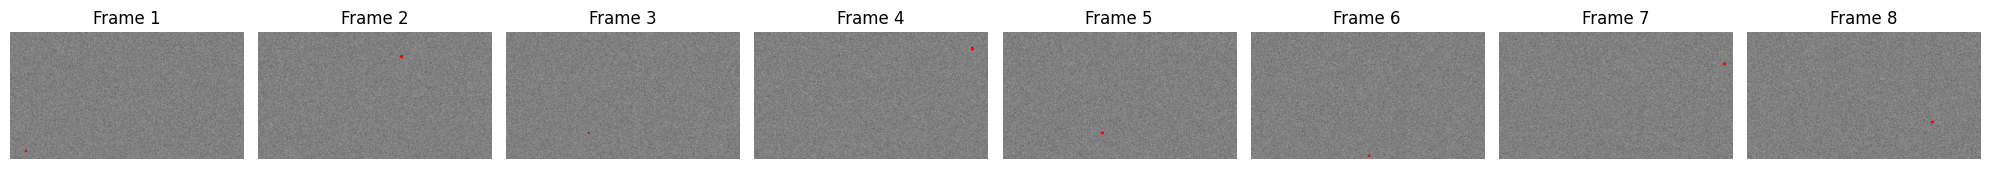

In [ ]:
# prompt: plot the frames in the train_loader batch size of 4

for features, labels in train_loader:
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))
    for i in range(8):
        frame_data = features[i].reshape(1080, 1980).cpu().numpy()
        ax = axes[i]
        ax.imshow(frame_data, cmap='grey')
        ax.set_title(f'Frame {i+1}')
        ax.axis('off')

        # Plot the bounding box
        x_min, y_min, x_max, y_max = labels[i].tolist()


        # Bounding box is defined by (x_min, y_min) as top-left corner and width, height
        # The data in labels seems to be (row_min, col_min) and (row_max, col_max)
        # For plotting, the x-coordinate is column and y-coordinate is row
        rect = patches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()
    break # Plot only the first batch

In [ ]:
linear_model = nn.Sequential(nn.Linear(2138400,1024), nn.Tanh(), nn.Linear(1024,512), nn.Tanh(), nn.Linear(512,4))


In [ ]:
linear_model.parameters()

<generator object Module.parameters at 0x7f32c060c900>

In [ ]:
linear_model

Sequential(
  (0): Linear(in_features=2138400, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
linear_model.to(device)

Sequential(
  (0): Linear(in_features=2138400, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
def trainin_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    for frames,y in train_loader:
      frames = frames.to(device)
      y_ground_truth = y.float()
      y_ground_truth = y_ground_truth.to(device)
      frames = frames.float()

    pred = model(frames)
    loss = loss_fn(pred, y_ground_truth)
    #logits = linear_model(train_loader)
    #loss = loss_fn(logits, y_ground_truth)
    if epoch % 100 == 0:
     print('Epoch %d, Loss %f' % (epoch, float(loss)))
    loss.backward()
    optimizer.step()
    metric = wandb.log({"loss": loss})
    optimizer.zero_grad()

In [ ]:
LR = 0.01

In [ ]:
optimizer = optim.Adam(linear_model.parameters(), lr = LR) # everyone say momentum doesnt work

In [ ]:
total_params = sum(p.numel() for p in linear_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2190249476


In [ ]:
linear_model.train()

Sequential(
  (0): Linear(in_features=2138400, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
wandb.watch(linear_model)
trainin_loop(n_epochs = 200, optimizer = optimizer, model = linear_model, loss_fn = nn.MSELoss(), train_loader=train_loader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.16 GiB. GPU 0 has a total capacity of 22.16 GiB of which 5.44 GiB is free. Process 9083 has 16.71 GiB memory in use. Of the allocated memory 16.38 GiB is allocated by PyTorch, and 102.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
linear_model.eval()

In [ ]:
x[0] = x[0].float().flatten()

In [ ]:
x[1]

In [ ]:
x[2]

In [ ]:
xx = x[0]

In [ ]:
xx.shape

In [ ]:
eval_pred = linear_model(xx)

In [ ]:
eval_pred